# Improving weld corner identificaiton

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# Add /scr/data folder to your system path
sys.path.append(os.pardir + '/src/data')

from segment_image import *

In [2]:
IMAGE_DIR = '../data/interim/merged_data/not_measured/'

In [8]:
f = '12.8x 2P-A33.jpg'

image = get_image(name, IMAGE_DIR)

threshold = get_threshold(image, norm=False) #keep as false 

binary = threshold_binary(image,threshold)

binary_cutoff = cut_scale_off(binary) # locate text and crop (top/bottom)

cropped_y1,  y_edges1 = crop_image_y(binary_cutoff) # outputs img and coords

cropped_x,  x_edges = crop_image_x(cropped_y1)

cropped_y2,  y_edges = crop_image_y(cropped_x)

cropped_area = get_area(cropped_y2)

In [9]:
x_edges

[(355, 2158), (array([19]), array([12]))]

In [10]:
print((y_edges1,y_edges,x_edges))

([345, 1470], [0, 1124], [(355, 2158), (array([19]), array([12]))])


Text(0.5, 1.0, 'binary')

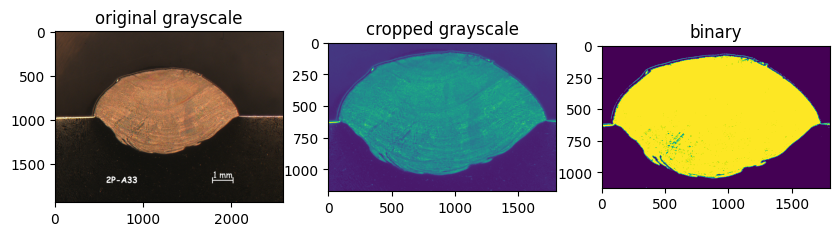

In [11]:
image = get_image(name, IMAGE_DIR)
gray  = rgb2gray(image)

gray  = gray[:locate_text_y(binary)]

cropped_gray = gray[y_edges1[0]+y_edges[0]:y_edges[1]+y_edges1[1],x_edges[0][0]:x_edges[0][1]]

fig, axes = plt.subplots(ncols=3, nrows = 1, figsize=(10, 5))
ax = axes.ravel()
ax[0].imshow(image)
ax[0].set_title('original grayscale')

ax[1].imshow(cropped_gray)
ax[1].set_title('cropped grayscale')

ax[2].imshow(cropped_y2)
ax[2].set_title('binary') 

In [13]:
img = image

In [32]:
img = get_image(image_name=f, input_dir=IMAGE_DIR)
gray = rgb2gray(img)
threshold = get_threshold(img, norm=False)
binary = threshold_binary(img, threshold)
binary_scale_cropped = cut_scale_off(binary)
for_ocr = only_scale(gray)

cropped4ocr_data = cropped_image_OCR(for_ocr, f)

id_text, same_as_filename = cropped4ocr_data[:2]
suggested_name_change = cropped4ocr_data[2]
dim_value, scale_read_success = cropped4ocr_data[3:5]
line_length, line_read_success = cropped4ocr_data[5:] 


In [33]:
f

'12.8x 2P-A33.jpg'

In [34]:
id_text, same_as_filename = cropped4ocr_data[:2]
suggested_name_change = cropped4ocr_data[2]
dim_value, scale_read_success = cropped4ocr_data[3:5]
line_length, line_read_success = cropped4ocr_data[5:] 


In [35]:

cropped_image_data = crop_image(binary_scale_cropped)
 
cropped, y_edges1, x_edges = cropped_image_data[:3]
y_edges2, h_left, h_right, h_flag = cropped_image_data[3:]
 
cropped_gray = gray[y_edges1[0]+y_edges2[0]:y_edges1[0] +
                    y_edges2[0]+y_edges2[1], x_edges[0][0]:x_edges[0][1]]
contoured = contour_image(cropped_gray)


In [36]:
contoured

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [37]:
measurements = get_measurements(contoured, img, f, y_edges1,
                                y_edges2, x_edges, h_left, h_right,
                                line_length, dim_value, '/home/dan_s/Desktop/')

height, width, depth, top_area, bottom_area, weld_dilution = measurements

In [45]:
image = contoured
bar = line_length
magni = dim_value
edges = feature.canny(image)
x_left = x_edges[0][0]
x_right = x_edges[0][1]
y_top_1 = y_edges1[0]
y_top_2 = y_edges2[0]
hline_left = h_left
hline_right = h_right



In [48]:

# Chacking that the scale bar was read successfully
try:
    bar_length = float(bar)
except IndexError:
    bar_length = 0
    
# Checking if the scale value was read successfully
try:
    mag = magni
except IndexError:
    mag = 0

if mag == ' ' or mag == '':
    mag = 0

mag = int(mag)

if bar_length == 0:
    px2mm = 1
    units = 'px'
else:
    px2mm = mag/bar_length
    units = 'mm'


y_values = [hline_left - y_top_1 - y_top_2,
            hline_right - y_top_1 - y_top_2]
y_mean = np.mean(y_values)
y_mean = int(y_mean)


In [91]:

# ---height
def get_height(image:np.ndarray, y_mean:int, px2mm:int)->tuple:    
    """measuring the height of the weld

    Args:
        image (np.ndarray): _description_
        y_mean (int): _description_
        px2mm (int): _description_

    Returns:
        height_x: The x-coordinate of the highest point on the curve
        height: The y-coordinate of the highest point on the curve
    """
    top = image[0:y_mean, :]
    top_edge = feature.canny(top)
    coords_top = np.argwhere(top_edge)
    y_top, _ = np.nonzero(top_edge)
    try:
        height = (top.shape[0] - np.min(y_top))
        height_x = coords_top[0][1]
        height *= px2mm
        height = np.round(height, 2)
    except ValueError:
        height = 0
        height_x = [0]
    return height_x, height


def get_depth(image:np.ndarray, y_mean:int, px2mm:int)->tuple:
    """measuring the depth of the weld

    Args:
        image (np.ndarray): _description_
        y_mean (int): _description_
        px2mm (int): _description_

    Returns:
        depth_x, depth: The xy-coordinates of the deepest point on the curve
    """

    bottom = image[y_mean: , :]
    bottom_edge = feature.canny(bottom)
    coords_bottom = np.argwhere(bottom_edge)
    y_bottom, x_bottom = np.nonzero(bottom_edge)
    try:
        depth = np.max(y_bottom)
        depth_x = coords_bottom[-1][1]
        depth *= px2mm
        depth = np.round(depth, 2)
    except ValueError:
        depth = 0
        depth_x = [0]
    return depth_x, depth


In [50]:
height_x, height = get_height(image, y_mean, px2mm)


In [88]:
def get_corners(image:np.ndarray, y_mean:int):
    """_summary_

    Args:
        image (np.ndarray): _description_
        y_mean (int): _description_

    Returns:
        corner_left, corner_right: x- coordinates of the weld corner
    """
    top = image[:y_mean, :]
    top_edge = feature.canny(top)
    ocoords_tp = np.argwhere(top_edge).transpose()
    mean_x = coords_top[1].mean()

    top_left_y = coords_top[0][np.where(coords_top[1] < mean_x)]
    top_right_y = coords_top[0][np.where(coords_top[1] > mean_x)]
    top_left_x = coords_top[1][np.where(coords_top[1] < mean_x)]
    top_right_x = coords_top[1][np.where(coords_top[1] > mean_x)]
    corner_left = max(top_left_x[np.where(top_left_y == top_left_y.max())])
    corner_right = min(top_right_x[np.where(top_right == top_right.max())])
    return corner_left, corner_right


In [89]:

# -- width
try:
    x_corner_l, x_corner_r = get_corners(image, y_mean)
    width = (x_corner_r - x_corner_l) * px2mm
    width = np.round(width, 2)
except ValueError:
    width = 0


In [100]:
np.power(2,3)

8

In [94]:
import statistics

Text(1518, 976, '2.28 mm')

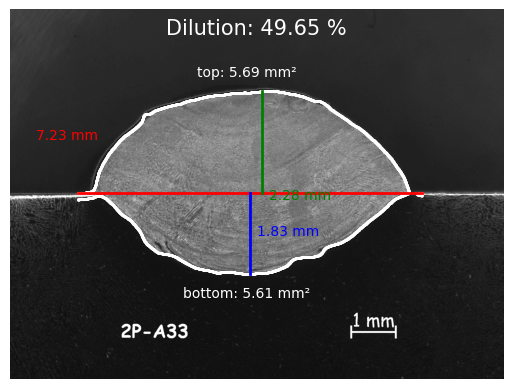

In [103]:

# --- depth
depth_x, depth = get_depth(image, y_mean, px2mm)

# Add line patch to image

# Create a line patch
x1, y1 = x_left, y_mean+y_top_1+y_top_2
x2, y2 = x_right, y_mean+y_top_1+y_top_2

# Plot image
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(gray, cmap='gray')

# Add line to plot
line = plt.Line2D((x1, x2), (y1, y2), color='r', linewidth=2)
ax.add_artist(line)

# Add text label to plot
text_location = (300, y_mean+y_top_1+y_top_2-300)
text_label = str(width) + ' ' + units
plt.text(text_location[0], text_location[1], text_label,
            color='r', fontsize=10, ha='center', va='center')

# --------- depth
x1, y1 = depth_x+x_left, y_mean+y_top_1+y_top_2
try:
    x2, y2 = depth_x+x_left, int(depth/px2mm) + y_mean+y_top_1+y_top_2
except ValueError:
    x2, y2 = depth_x+x_left, y_mean+y_top_1+y_top_2

# Add line to plot
line = plt.Line2D((x1, x2), (y1, y2), color='b', linewidth=2)
ax.add_artist(line)

# Add text label to plot
text_location = (depth_x+x_left + 200, y_mean+y_top_1+y_top_2 + 200)
text_label = str(depth) + ' ' + units
plt.text(text_location[0], text_location[1], text_label,
            color='b', fontsize=10, ha='center', va='center')

# Plotting the height
x1, y1 = height_x+x_left, y_mean+y_top_1+y_top_2
try:
    x2, y2 = height_x+x_left, y_mean - int(height/px2mm)+y_top_1+y_top_2
except ValueError:
    x2, y2 = height_x+x_left, y_top_1+y_top_2

# Add line to plot
line = plt.Line2D((x1, x2), (y1, y2), color='g', linewidth=2)
ax.add_artist(line)

y_edges, x_edges = np.nonzero(edges)
y_edges += (y_top_1+y_top_2)
x_edges += x_left

plt.scatter(x_edges, y_edges, s=0.5, c='white')

# Calculating the area
top = image[:y_mean, :]
top_edge = feature.canny(top)
coords_top = np.argwhere(top_edge).transpose()
top_area = coords_top[0][x_corner_l:x_corner_r].sum()*px2mm*px2mm
top_area = np.round(top_area, 2)

bottom = image[y_mean:, :]
bottom_edge = feature.canny(bottom)
coords_bottom = np.argwhere(bottom_edge).transpose()
bottom_area = coords_bottom[0][x_corner_l:x_corner_r].sum()*px2mm*px2mm
bottom_area = np.round(bottom_area, 2)

# Calculating dilution
weld_dilution = 100 * (bottom_area / (bottom_area + top_area))
weld_dilution = np.round(weld_dilution, 2)
try:
    text_location = (statistics.mean(x_edges), y_edges.min()-100)
except:
    text_location = (1000, 500)
text_label = 'top: ' + str(top_area) + ' ' + units + '²'
plt.text(text_location[0], text_location[1], text_label,
            color='w', fontsize=10, ha='center', va='center')

try:
    text_location = (statistics.mean(x_edges), y_edges.max()+100)
except:
    text_location = (1000, 1000)
text_label = 'bottom: ' + str(bottom_area) + ' ' + units + '²'
plt.text(text_location[0], text_location[1], text_label,
            color='w', fontsize=10, ha='center', va='center')

text_location = (round(gray.shape[1]/2), 100)
text_label = 'Dilution: ' + str(weld_dilution) + ' %'
plt.text(text_location[0], text_location[1], text_label,
            color='w', fontsize=15, ha='center', va='center')

# Add text label to plot
try:
    text_location = (height_x+x_left + 200,
                    int(height/px2mm)+y_top_1+y_top_2 + 100)
except ValueError:
    text_location = (height_x+x_left + 200,
                        y_top_1+y_top_2 + 100)
text_label = str(height) + ' ' + units
plt.text(text_location[0], text_location[1], text_label,
            color='g', fontsize=10, ha='center', va='center')

